### Projekt symulacji Monte Carlo dla cen akcji Facebook inc.



In [2]:
import Pkg
import Conda

ArgumentError: ArgumentError: Package CSV not found in current path:
- Run `import Pkg; Pkg.add("CSV")` to install the CSV package.


In [30]:
# import potrzebnych bibliotek

# Pkg.add("CSV")
# Pkg.add("DataFrames")
# Pkg.add("PyCall")
# Pkg.add("PyPlot")

using PyPlot, Statistics, CSV, PyCall, DataFrames, Distributions

In [23]:
# import zbioru

df = CSV.read("facebooks_stocks.csv");

In [24]:
head(df)

┌ Warning: `head(df::AbstractDataFrame)` is deprecated, use `first(df, 6)` instead.
│   caller = top-level scope at In[24]:1
└ @ Core In[24]:1


,Date,Close
,Dates…⍰,Float64⍰
1,2015-01-02,78.45
2,2015-01-05,77.19
3,2015-01-06,76.15
4,2015-01-07,76.15
5,2015-01-08,78.175
6,2015-01-09,77.74


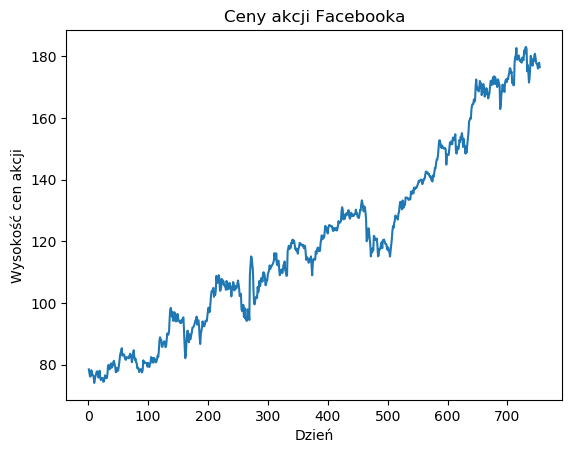

show (generic function with 387 methods)

In [29]:
plot(1:nrow(df),df.Close)
title("Ceny akcji Facebooka")
ylabel("Wysokość cen akcji")
xlabel("Dzień")
show

In [25]:
# zmiana procentowa cen akcji wzgledem dnia poprzedniego

pct_change = [0.0]
for i in 1:nrow(df)-1
    append!(pct_change, (df.Close[i+1]/df.Close[i])/100)
end

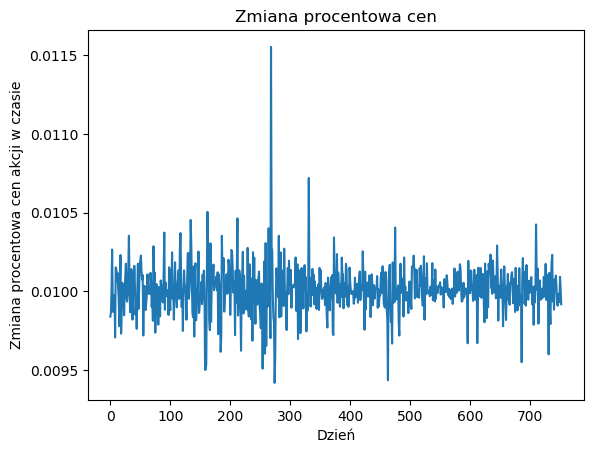

show (generic function with 387 methods)

In [5]:
plot(pct_change[2:length(pct_change)])
title("Zmiana procentowa cen")
ylabel("Zmiana procentowa cen akcji w czasie")
xlabel("Dzień")
show

In [6]:
# logarytm ze zmiany procentowej

log_returns = []
for i in 1:length(pct_change)
    append!(log_returns, log((ones(length(pct_change),1) + pct_change)[i]))
end

In [22]:
# średnia
av = mean(log_returns);

# wariancja
variation = var(log_returns);

# dryft
drift = av - (0.5*variation);

# odchylenie standardowe
stdev = std(log_returns);

### Ruchy Browna  

r = drift + stdev $\cdot$ $e^r$

In [46]:
function monte_carlo_simulation(days,simulations,drift,stdev)
    # losowanie z rozkładu normalnego o danym prawdopdobieństwie
    sim_rand = rand(days,simulations)
    Z = []

    for i in 1:simulations
        for j in 1:days
            append!(Z,quantile(Normal(),sim_rand[j,i]))
        end
    end
    
    # ruch Browna
    daily_returns = []
    for i in 1:length(Z)
        append!(daily_returns, exp(drift + stdev * Z[i]))
    end

    daily_returns = reshape(daily_returns,days,simulations)
    
    # Cena akcji z ostatniego dnia z ramki danych
    last_price = df.Close[end]

    # generowanie tablicy z ostatnią wyceną akcji
    price_pred = zeros(length(daily_returns))

    for i in 1:days:days*simulations
        price_pred[i] = last_price
    end

    price_pred = reshape(price_pred,days,simulations)
    
    for j in 1:simulations
        for i in 2:days
            price_pred[i,j] = price_pred[i-1,j] * daily_returns[i,j]
        end
    end

    price_pred = reshape(price_pred,days,simulations)
   
    return price_pred, daily_returns, Z
end

monte_carlo_simulation (generic function with 1 method)

In [47]:
# ustalenie liczby symulacji i dni predykcji

days = 100
simulations = 10

# wywołanie symulacji

price_predictions, daily_returns, Z = monte_carlo_simulation(days,simulations,drift,stdev)

([176.46 176.46 … 176.46 176.46; 178.312 178.317 … 178.303 178.128; … ; 464.947 467.049 … 468.03 467.137; 469.755 471.667 … 472.544 471.858], Any[1.01017 1.01002 … 1.01014 1.01016; 1.0105 1.01052 … 1.01045 1.00945; … ; 1.01029 1.00968 … 1.01097 1.01006; 1.01034 1.00989 … 1.00964 1.01011], Any[0.440951, 1.25741, 1.41943, 0.0646202, -2.74952, -1.13575, 0.367009, -0.893009, 1.25824, -0.639608  …  -0.103545, -0.445926, -2.72226, 0.482975, -1.48625, 0.313088, -0.712833, -1.93962, 0.162718, 0.272137])

In [50]:
daily_returns

100×10 Array{Any,2}:
 1.01017  1.01002  1.0092   1.00992  …  1.0097   1.01014  1.01014  1.01016
 1.0105   1.01052  1.00938  1.00987     1.00987  1.00968  1.01045  1.00945
 1.01056  1.00958  1.01028  1.00885     1.01006  1.01029  1.01023  1.01024
 1.01002  1.00931  1.00978  1.01059     1.00954  1.01054  1.01036  1.0104 
 1.00891  1.00955  1.01001  1.00981     1.0094   1.00957  1.00996  1.00945
 1.00955  1.00963  1.01014  1.00994  …  1.00973  1.01023  1.0107   1.01034
 1.01014  1.01051  1.01019  1.00998     1.01037  1.00993  1.00998  1.00992
 1.00964  1.01013  1.00987  1.00987     1.00993  1.00996  1.00997  1.01059
 1.0105   1.00976  1.00935  1.00975     1.00931  1.01015  1.01018  1.01043
 1.00974  1.00913  1.0103   1.01        1.00962  1.00976  1.00945  1.01091
 1.01006  1.00979  1.00993  1.01025  …  1.01031  1.01016  1.01013  1.00984
 1.01049  1.01015  1.00979  1.00991     1.01017  1.00987  1.00933  1.01048
 1.0098   1.01035  1.01014  1.01014     1.00923  1.01049  1.01022  1.01019
 ⋮  

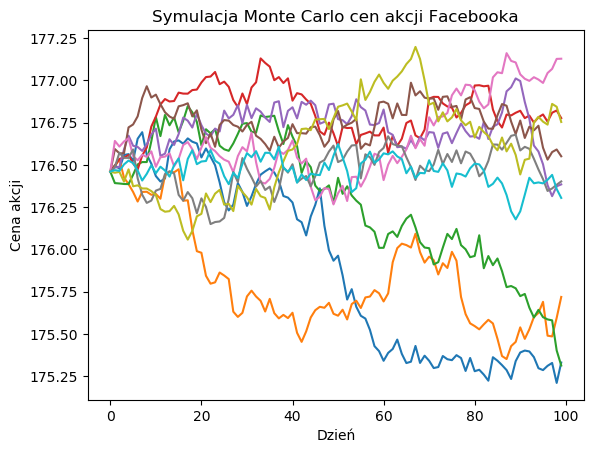

show (generic function with 387 methods)

In [39]:
plot(price_predictions)
xlabel("Dzień")
ylabel("Cena akcji")
title("Symulacja Monte Carlo cen akcji Facebooka")
show

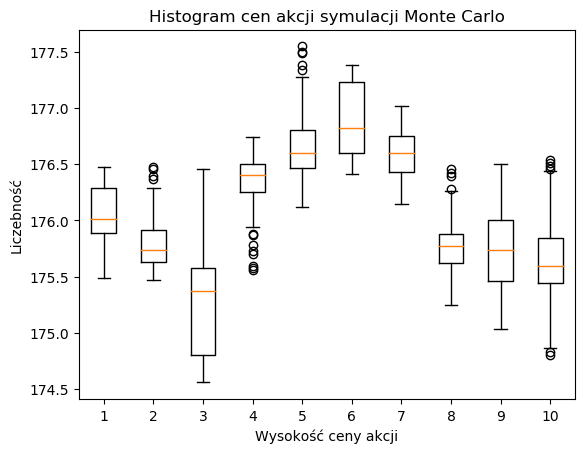

show (generic function with 387 methods)

In [19]:
boxplot(price_predictions)
title("Histogram cen akcji symulacji Monte Carlo")
xlabel("Wysokość ceny akcji")
ylabel("Liczebność")
show

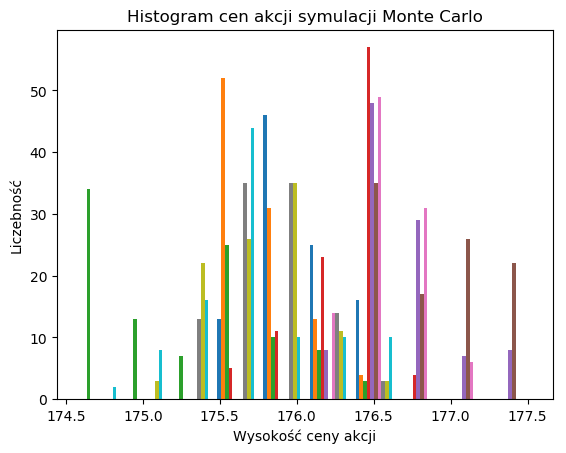

show (generic function with 387 methods)

In [21]:
hist(price_predictions)
title("Histogram cen akcji symulacji Monte Carlo")
xlabel("Wysokość ceny akcji")
ylabel("Liczebność")
show

In [27]:
# wprowadzenie predykcji do ramki danych

df_pred = DataFrame(price_predictions);